<a href="https://colab.research.google.com/github/IsaacFigNewton/Cyclic-Decision-Graph-Generator/blob/main/Modified_ID3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Config

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Import Libraries

In [ ]:
import pandas as pd
import math
import numpy as np

import sklearn as sk
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans,\
                            SpectralClustering
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV,\
                            KFold
from sklearn.metrics import precision_score,\
                            recall_score,\
                            accuracy_score,\
                            f1_score,\
                            make_scorer,\
                            silhouette_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn import tree

import matplotlib.pyplot as plt

#Important Functions and Classes

## Discretization
for discretizing continuous quantitative data

In [ ]:
# Custom scorer for silhouette score
def silhouette_scorer(estimator, X):
    transformed_data = estimator.transform(X)
    if len(np.unique(transformed_data)) > 1:
        kmeans = KMeans(n_clusters=len(np.unique(transformed_data)))
        cluster_labels = kmeans.fit_predict(transformed_data)
        return silhouette_score(transformed_data, cluster_labels)
    else:
        return -1  # If only one cluster, silhouette score is not defined

## Tree composition

Based on code from serengil's repository
https://github.com/serengil/decision-trees-for-ml/tree/master

In [ ]:
def calculateEntropy(df):
    """
    Calculate the entropy of the given dataset.

    Args:
    df (pandas.DataFrame): The dataset containing the 'Decision' column.

    Returns:
    float: The calculated entropy value.
    """
    # Get the number of instances in the dataset
    instances = df.shape[0]
    decisions = df['Decision']\
                    .value_counts()\
                    .keys()\
                    .tolist()
    entropy = 0

    for decision in decisions:
        # Calculate the probability of each decision class
        num_of_decisions = df['Decision']\
                              .value_counts()[decision]
        class_probability = num_of_decisions / instances

        # Calculate the entropy for each class
        if class_probability > 0:
            entropy -= class_probability * np.log2(class_probability)

    return entropy

In [ ]:
def findDecision(df):
    """
    Find the best feature to split the dataset on using the ID3 algorithm.

    Args:
    df (pandas.DataFrame): The dataset to analyze.

    Returns:
    str: The name of the feature with the highest information gain.
    """
    # Calculate the entropy of the entire dataset
    entropy = calculateEntropy(df)

    # Get the number of columns (features + target) and instances (rows) in the dataset
    columns = df.shape[1]
    instances = df.shape[0]

    # List to store the information gain for each feature
    gains = []

    # Loop through each feature (excluding the target column)
    for column in df.columns:                                 # Get the name of the current feature
        if column != "Decision":
            classes = df[column].value_counts()              # Count the occurrences of each class in the feature
            gain = entropy                                        # Start with the entropy of the entire dataset

            # Calculate information gain for each class in the current feature
            for current_class in classes.keys():
                # Create a subset of the dataset where the current feature equals the current class
                subdataset = df[df[column] == current_class]
                subset_instances = subdataset.shape[0]            # Number of instances in the subset
                class_probability = subset_instances / instances  # Probability of the current class
                subset_entropy = calculateEntropy(subdataset)     # Calculate the entropy of the subset

                # Update the information gain by subtracting the weighted entropy of the subset
                gain -= class_probability * subset_entropy

            # Append the calculated information gain for the current feature to the list
            gains.append(gain)

    # Find the index of the feature with the maximum information gain
    winner_index = gains.index(max(gains))
    winner_name = df.columns[winner_index]                    # Get the name of the feature with the highest information gain

    return winner_name  # Return the name of the best feature to split on

In [ ]:
def buildDecisionTree(df):
    """
    Recursively build the ID3 decision tree.

    Args:
    df (pandas.DataFrame): The dataset to build the tree from.

    Returns:
    dict: A dictionary representing the decision tree.
    """

    # Check if 'Decision' column exists
    if 'Decision' not in df.columns:
        raise KeyError("The 'Decision' column is missing from the DataFrame.")

    # Check if all instances have the same decision
    if len(df['Decision'].unique()) == 1:
        return df['Decision'].iloc[0]

    # Check if there are no more features to split on
    if df.shape[1] == 1:
        return df['Decision']\
                    .value_counts()\
                    .idxmax()

    # Find the best feature to split on
    winner_name = findDecision(df)
    tree = {winner_name: {}}

    # If all features have been exhausted without a definite winner,
    #   use the majority class for classification
    if winner_name == "Decision":
        return df['Decision']\
                    .value_counts()\
                    .idxmax()

    # Split the dataset based on the best feature
    for current_class in df[winner_name].unique():
        # Create a subset of the dataset based on the current class
        # print(f"Splitting on {winner_name} = {current_class}")
        subdataset = df[df[winner_name] == current_class].drop(columns=[winner_name])

        if 'Decision' not in subdataset.columns:
            print("The 'Decision' column is missing from the subdataset.")

        # Recursively build the decision tree for the subset
        tree[winner_name][current_class] = buildDecisionTree(subdataset)

    return tree

In [ ]:
def predict(tree, instance):
    """
    Make a prediction for a single instance using the decision tree.

    Args:
    tree (dict): The decision tree.
    instance (pandas.Series): A single instance to classify.

    Returns:
    str: The predicted class.
    """

    # Check if the tree is a leaf node
    if not isinstance(tree, dict):
        return tree

    # Find the root of the tree
    root = list(tree.keys())[0]

    # Check if the value of the instance is in the tree
    if instance[root] in tree[root]:
        # Recursively make a prediction for the instance
        return predict(tree[root][instance[root]], instance)
    else:
        # If the value is not in the tree, return the most common class
        # Find the most common class among the subtrees
        subtree_classes = [key for key in tree[root].keys() if isinstance(tree[root][key], str)]
        if subtree_classes:
            return max(subtree_classes, key=lambda k: len(tree[root][k]) if isinstance(tree[root][k], dict) else 0)
        else:
            # Fallback to return 0
            return 0


In [ ]:
def print_tree(tree, indent=0):
    """
    Print the decision tree in a readable format.

    Args:
    tree (dict): The decision tree.
    indent (int): The number of spaces to indent each level of the tree.
    """

    # Iterate over the keys (features) in the tree
    for key, value in tree.items():
        print(' ' * indent + str(key))
        # If the value is a dictionary, recursively print the subtree
        if isinstance(value, dict):
            print_tree(value, indent + 4)
        else:
            print(' ' * (indent + 4) + str(value))

# Run code

In [ ]:
# Prepare for k-fold cross-validation
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Lists to store evaluation metrics
precisions, recalls, accuracies, f1_scores = [], [], [], []

## Load the dataset

In [ ]:
# # Death Penalty
# df = pd.read_csv("https://raw.githubusercontent.com/dlsun/pods/master/data/death_penalty.csv")
# df.dropna(inplace=True)

# # Identify categorical, continuous, and binary columns
# categorical_features = ["Defendant's Race", "Victim's Race"]
# continuous_features = []
# y = ['Death Penalty']

In [ ]:
# Golf
df = pd.read_csv("https://raw.githubusercontent.com/serengil/decision-trees-for-ml/master/dataset/golf.txt")

# Identify categorical, continuous, and binary columns
categorical_features = ["Outlook", "Temp.", "Humidity", "Wind"]
continuous_features = []
y = ["Decision"]

In [ ]:
# Load the dataset
# # Titanic
# df = pd.read_csv("https://raw.githubusercontent.com/dlsun/pods/master/data/titanic.csv")
# df.drop(columns=["name", "ticketno"], inplace=True)
# df.dropna(inplace=True)

# # Identify categorical, continuous, and binary columns
# categorical_features = ["gender", "embarked", "class", "country"]
# continuous_features = ["age", "fare"]
# y = ['survived']

In [ ]:
# # Bordeaux Wines
# df = pd.read_csv("https://raw.githubusercontent.com/dlsun/pods/master/data/bordeaux.csv")
# df.dropna(inplace=True)

# # Identify categorical, continuous, and binary columns
# categorical_features = []
# continuous_features = ["year","summer","har","sep","win","age"]
# y = ["price"]

In [ ]:
# Define feature columns and target column
X = categorical_features + continuous_features

## Sklearn's Built-in DT

In [ ]:
df.head()

,Outlook,Temp.,Humidity,Wind,Decision
0,Sunny,Hot,High,Weak,No
1,Sunny,Hot,High,Strong,No
2,Overcast,Hot,High,Weak,Yes
3,Rain,Mild,High,Weak,Yes
4,Rain,Cool,Normal,Weak,Yes


In [ ]:
if len(categorical_features) > 0:
    transformers=[
            ('cat', OneHotEncoder(handle_unknown="ignore"), categorical_features),
            ('num', 'passthrough', continuous_features)
    ]
else:
    transformers=[
            ('num', 'passthrough', continuous_features)
    ]

# Create a pipeline with preprocessor and DecisionTreeClassifier
pipeline = Pipeline(steps=[
    ('preprocessor', ColumnTransformer(transformers = transformers)),
    ('classifier', DecisionTreeClassifier())
])

In [ ]:
# Split the data into training and test sets
fold = 1
for train_index, test_index in kf.split(df):
    print(f"Fold {fold}")

    # Split the data
    train_data = df.iloc[train_index]
    test_data = df.iloc[test_index]

    # Leave out entries in one dataset but not the other
    entries_to_omit = set()
    for col in categorical_features:
        entries_to_omit = set(train_data[col].unique())\
                                    .symmetric_difference(set(test_data[col].unique()))

        # drop bad entries
        for value in entries_to_omit:
            train_data = train_data[train_data[col] != value]
            test_data = test_data[test_data[col] != value]

    # Train the pipeline
    pipeline.fit(train_data[X], train_data[y])

    # Predict and evaluate the model
    y_true = test_data[y]
    y_pred = pipeline.predict(test_data[X])

    # Calculate metrics using sklearn
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    precisions.append(precision)
    recalls.append(recall)
    accuracies.append(accuracy)
    f1_scores.append(f1)

    # # Print the decision tree
    # print_tree(tree)
    # print()

    # print(f"Precision: {precision:.4f}")
    # print(f"Recall: {recall:.4f}")
    # print(f"Accuracy: {accuracy:.4f}")
    # print(f"F1 Score: {f1:.4f}")
    # print()

    # Increment the fold index
    fold += 1

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5



Average Scores:
Precision: 0.6889 (+/- 0.2548)
Recall: 0.6667 (+/- 0.2108)
Accuracy: 0.6667 (+/- 0.2108)
F1 Score: 0.6400 (+/- 0.2175)


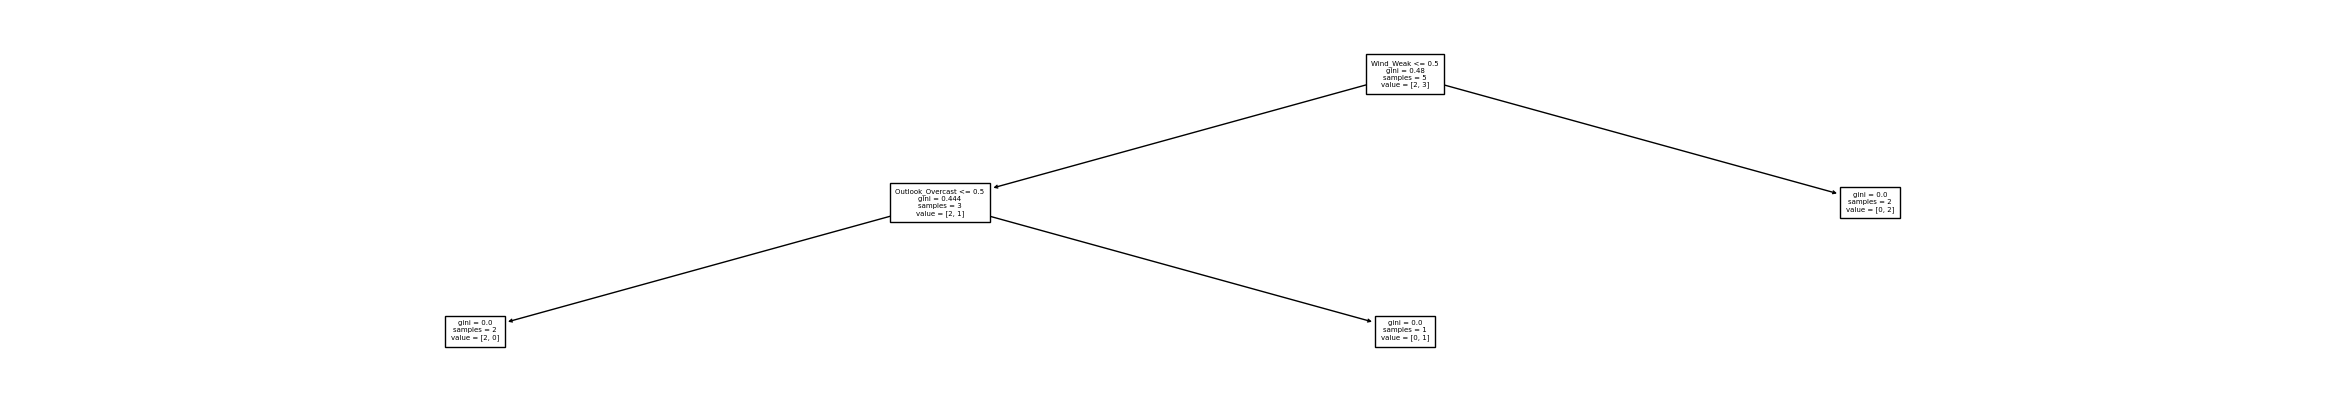

In [ ]:
# Print the decision tree

# Create a figure and axis with a wider x-axis
fig, ax = plt.subplots(figsize=(30, 5))

feature_names = continuous_features
if len(categorical_features) > 0:
  # Extract feature names after OneHotEncoding
  feature_names = (pipeline.named_steps['preprocessor']
                    .transformers_[0][1]
                    .get_feature_names_out(categorical_features)  # Get feature names for categorical features
                    .tolist() +
                    continuous_features)



# Plot the decision tree
sk.tree.plot_tree(pipeline.named_steps['classifier'],
               max_depth=5,
               feature_names=feature_names,
               fontsize=5,
               ax=ax)

# Save average scores
avg_scores = dict()
avg_scores["sklearn"] = {
    "precision": np.mean(precisions),
    "recall": np.mean(recalls),
    "accuracy": np.mean(accuracies),
    "f1": np.mean(f1_scores),
    "std_precision": np.std(precisions),
    "std_recall": np.std(recalls),
    "std_accuracy": np.std(accuracies),
    "std_f1": np.std(f1_scores),
}

# Print average scores
print()
print("Average Scores:")
print(f"Precision: {avg_scores['sklearn']['precision']:.4f} (+/- {avg_scores['sklearn']['std_precision']:.4f})")
print(f"Recall: {avg_scores['sklearn']['recall']:.4f} (+/- {avg_scores['sklearn']['std_recall']:.4f})")
print(f"Accuracy: {avg_scores['sklearn']['accuracy']:.4f} (+/- {avg_scores['sklearn']['std_accuracy']:.4f})")
print(f"F1 Score: {avg_scores['sklearn']['f1']:.4f} (+/- {avg_scores['sklearn']['std_f1']:.4f})")

## Custom Approach

In [ ]:
#Get the column with the classification
df.rename(columns={y[0]: 'Decision'}, inplace=True)

In [ ]:
df.head()

,Outlook,Temp.,Humidity,Wind,Decision
0,Sunny,Hot,High,Weak,No
1,Sunny,Hot,High,Strong,No
2,Overcast,Hot,High,Weak,Yes
3,Rain,Mild,High,Weak,Yes
4,Rain,Cool,Normal,Weak,Yes


### Cluster and Discretize Data

In [ ]:
# Detect continuous quantitative variables
continuous_variables = [col for col in df.select_dtypes(include=['float64', 'int64']).columns if df[col].nunique() > 10]
print(continuous_variables)

[]


In [ ]:
if len(continuous_variables) > 1:
    # Cluster the continuous variables
    print(f"Clustering...")

    # Create the pipeline
    clusterer = KMeans(random_state=42)
    pipeline = Pipeline([
        ('clusterer', clusterer)
    ])

    # Perform GridSearchCV to find the best number of bins
    grid_search = GridSearchCV(pipeline,\
                                {'clusterer__n_clusters': np.arange(2, 5)},\
                                scoring=make_scorer(silhouette_scorer, greater_is_better=True),\
                                cv=5)
    grid_search.fit(df[continuous_variables])

    # Get the best estimator
    best_clusterer = grid_search\
                        .best_estimator_\
                        .named_steps['clusterer']

    # Discretize data
    df["cluster"] = best_clusterer.fit_predict(df[continuous_variables])

In [ ]:
df.head()

,Outlook,Temp.,Humidity,Wind,Decision
0,Sunny,Hot,High,Weak,No
1,Sunny,Hot,High,Strong,No
2,Overcast,Hot,High,Weak,Yes
3,Rain,Mild,High,Weak,Yes
4,Rain,Cool,Normal,Weak,Yes


In [ ]:
# Discretizer the continuous variables
for var in continuous_variables:
    print(f"Discretizing {var}...")

    # Create the pipeline
    pipeline = Pipeline([
        ('discretizer', KBinsDiscretizer())
    ])

    # Perform GridSearchCV to find the best number of bins
    grid_search = GridSearchCV(pipeline,\
                                {'discretizer__n_bins': np.arange(2, 5),
                                'discretizer__strategy': ['uniform', 'quantile', 'kmeans']},\
                                scoring=make_scorer(silhouette_scorer, greater_is_better=True),\
                                cv=5)
    grid_search.fit(df[[var]])

    # Get the best estimator
    best_discretizer = grid_search\
                        .best_estimator_\
                        .named_steps['discretizer']

    # Discretize data, convert sparse matrix to dense and flatten to 1D
    clusters = best_discretizer\
                                .fit_transform(df[[var]])\
                                .toarray()

    # Create a DataFrame from the dense matrix
    clusters_df = pd.DataFrame(clusters)

    # Convert the binary matrix to unique class labels
    # Combine rows into tuples and then into unique labels
    clusters_df['class_label'] = clusters_df.apply(lambda row: tuple(row), axis=1)
    clusters_df['class_label'] = clusters_df['class_label'].astype('category').cat.codes

    # Add the class labels to the results DataFrame
    df["discretized_" + var] = clusters_df['class_label']

In [ ]:
df.head()

,Outlook,Temp.,Humidity,Wind,Decision
0,Sunny,Hot,High,Weak,No
1,Sunny,Hot,High,Strong,No
2,Overcast,Hot,High,Weak,Yes
3,Rain,Mild,High,Weak,Yes
4,Rain,Cool,Normal,Weak,Yes


### Classify Data

In [ ]:
if len(continuous_variables) > 0 and continuous_variables[0] in df.columns:
    columns_to_drop = [col for col in continuous_variables if col != 'Decision']
    df.drop(columns=columns_to_drop, inplace=True)

In [ ]:
df.head()

,Outlook,Temp.,Humidity,Wind,Decision
0,Sunny,Hot,High,Weak,No
1,Sunny,Hot,High,Strong,No
2,Overcast,Hot,High,Weak,Yes
3,Rain,Mild,High,Weak,Yes
4,Rain,Cool,Normal,Weak,Yes


In [ ]:
# Perform k-fold cross-validation
fold = 1
for train_index, test_index in kf.split(df):
    print(f"Fold {fold}")

    # Split the data
    train_data = df.iloc[train_index]
    test_data = df.iloc[test_index]

    # Build the decision tree
    tree = buildDecisionTree(train_data)

    # Make predictions
    y_true = test_data['Decision']
    y_pred = test_data.apply(lambda x: predict(tree, x), axis=1)

    # Calculate metrics using sklearn
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    precisions.append(precision)
    recalls.append(recall)
    accuracies.append(accuracy)
    f1_scores.append(f1)

    # # Print the decision tree
    # print_tree(tree)
    # print()

    # print(f"Precision: {precision:.4f}")
    # print(f"Recall: {recall:.4f}")
    # print(f"Accuracy: {accuracy:.4f}")
    # print(f"F1 Score: {f1:.4f}")
    # print()

    # Increment the fold index
    fold += 1

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5


In [ ]:
# Print the decision tree
print_tree(tree)
print()


# Save average scores
avg_scores["custom"] = {
    "precision": np.mean(precisions),
    "recall": np.mean(recalls),
    "accuracy": np.mean(accuracies),
    "f1": np.mean(f1_scores),
    "std_precision": np.std(precisions),
    "std_recall": np.std(recalls),
    "std_accuracy": np.std(accuracies),
    "std_f1": np.std(f1_scores)
}

# Print average scores
print()
print("Average Scores:")
print(f"Precision: {np.mean(precisions):.4f} (+/- {np.std(precisions):.4f})")
print(f"Recall: {np.mean(recalls):.4f} (+/- {np.std(recalls):.4f})")
print(f"Accuracy: {np.mean(accuracies):.4f} (+/- {np.std(accuracies):.4f})")
print(f"F1 Score: {np.mean(f1_scores):.4f} (+/- {np.std(f1_scores):.4f})")

Outlook
    Sunny
        Humidity
            High
                No
            Normal
                Yes
    Overcast
        Yes
    Rain
        Wind
            Weak
                Yes
            Strong
                No


Average Scores:
Precision: 0.8111 (+/- 0.2373)
Recall: 0.7667 (+/- 0.2603)
Accuracy: 0.7667 (+/- 0.2603)
F1 Score: 0.7644 (+/- 0.2526)


# Compare models

In [ ]:
for model_name, scores in avg_scores.items():
      print(f"{model_name}:")
      print(f"Precision: {scores['precision']:.4f} (+/- {scores['std_precision']:.4f})")
      print(f"Recall: {scores['recall']:.4f} (+/- {scores['std_recall']:.4f})")
      print(f"Accuracy: {scores['accuracy']:.4f} (+/- {scores['std_accuracy']:.4f})")
      print(f"F1 Score: {scores['f1']:.4f} (+/- {scores['std_f1']:.4f})")
      print()

sklearn:
Precision: 0.6889 (+/- 0.2548)
Recall: 0.6667 (+/- 0.2108)
Accuracy: 0.6667 (+/- 0.2108)
F1 Score: 0.6400 (+/- 0.2175)

custom:
Precision: 0.8111 (+/- 0.2373)
Recall: 0.7667 (+/- 0.2603)
Accuracy: 0.7667 (+/- 0.2603)
F1 Score: 0.7644 (+/- 0.2526)

